In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competition-01/train_kaggle.csv
/kaggle/input/competition-01/test_kaggle.csv
/kaggle/input/competition-dataset/test_kaggle.csv
/kaggle/input/competition-dataset/train_kaggle-2.csv
/kaggle/input/predictions-csv/predictions.csv


# Loading all required libraries

In [2]:
# Loading All Libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


In [3]:
# Loading the datsets
train_data = pd.read_csv('/kaggle/input/competition-dataset/train_kaggle-2.csv')
test_data = pd.read_csv('/kaggle/input/competition-dataset/test_kaggle.csv')

/tmp/ipykernel_33/3956906120.py:2: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('/kaggle/input/competition-dataset/train_kaggle-2.csv')


In [4]:
train_data.head()

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_catgeory
0,10493832.0,Kelaniya,1209.6,756.0,5292.0,4
1,10178643.0,Moratuwa,1590.12,1060.08,6007.12,1
2,10513916.0,Wattala,2288.88,1481.04,9155.52,4
3,10334589.0,Wattala,2274.94,1739.66,9099.76,4
4,10458365.0,Kelaniya,2345.49,2069.55,9243.99,4


In [5]:
# Check for missing values in each column
missing_values = test_data.isnull().sum()

# Print the count of missing values in each column
missing_values

Customer_ID     0
outlet_city     0
luxury_sales    0
fresh_sales     0
dry_sales       0
dtype: int64

In [6]:
test_data.head()

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales
0,33574,batticaloa,2686.5,3582,12537
1,10089,batticaloa,1717.56,2576.34,9446.58
2,38329,batticaloa,854.04,1242.24,5201.88
3,11376,batticaloa,1638.12,2320.67,9282.68
4,12410,batticaloa,1039.09,1518.67,5435.24


In [7]:
duplicate_customer_ids = test_data[test_data.duplicated(['Customer_ID'], keep=False)]

if len(duplicate_customer_ids) > 0:
    print("Duplicate Customer_IDs found:")
    print(duplicate_customer_ids[['Customer_ID']])
else:
    print("No duplicate Customer_IDs found.")

No duplicate Customer_IDs found.


In [8]:
train_data.shape

(774155, 6)

In [9]:
test_data.shape

(40749, 5)

# Data Preprocessing & Exploratory Data Analysis

In [10]:
# Check the data types for training data
train_data.dtypes

Customer_ID         float64
outlet_city          object
luxury_sales         object
fresh_sales          object
dry_sales            object
cluster_catgeory     object
dtype: object

In [11]:
# Check the data types for testing data
test_data.dtypes

Customer_ID      int64
outlet_city     object
luxury_sales    object
fresh_sales     object
dry_sales       object
dtype: object

When looking at this dataset it was noticed that there are some non-numeric data where its supposed to be numeric. To address this issue, the sales columns were converted to numeric and any numerics were replaced with NaN for initial processing.

In [12]:
# Replace non-numeric values with NaN for training data
train_data['luxury_sales'] = pd.to_numeric(train_data['luxury_sales'], errors='coerce')
train_data['fresh_sales'] = pd.to_numeric(train_data['fresh_sales'], errors='coerce')
train_data['dry_sales'] = pd.to_numeric(train_data['dry_sales'], errors='coerce')

In [13]:
# Replace non-numeric values with NaN for testing data
test_data['luxury_sales'] = pd.to_numeric(test_data['luxury_sales'], errors='coerce')
test_data['fresh_sales'] = pd.to_numeric(test_data['fresh_sales'], errors='coerce')
test_data['dry_sales'] = pd.to_numeric(test_data['dry_sales'], errors='coerce')

Next the datatypes were converted

In [14]:
# Convert Data Types Accordingly
# Convert Customer_ID to string
train_data['Customer_ID'] = train_data['Customer_ID'].astype(str)
test_data['Customer_ID'] = test_data['Customer_ID'].astype(str)

# Convert luxury_sales, fresh_sales, and dry_sales to float
train_data['luxury_sales'] = train_data['luxury_sales'].astype(float)
train_data['fresh_sales'] = train_data['fresh_sales'].astype(float)
train_data['dry_sales'] = train_data['dry_sales'].astype(float)

# Convert luxury_sales, fresh_sales, and dry_sales to float
test_data['luxury_sales'] = test_data['luxury_sales'].astype(float)
test_data['fresh_sales'] = test_data['fresh_sales'].astype(float)
test_data['dry_sales'] = test_data['dry_sales'].astype(float)

In [15]:
# Check the data types
train_data.dtypes

Customer_ID          object
outlet_city          object
luxury_sales        float64
fresh_sales         float64
dry_sales           float64
cluster_catgeory     object
dtype: object

In [16]:
test_data.dtypes

Customer_ID      object
outlet_city      object
luxury_sales    float64
fresh_sales     float64
dry_sales       float64
dtype: object

In [17]:
train_data.describe()

,luxury_sales,fresh_sales,dry_sales
count,774110.000000,774105.000000,774117.000000
mean,1921.965255,4428.680047,4676.280399
std,1004.078513,3334.654673,3409.386733
min,500.000000,500.000000,500.000000
25%,1213.530000,1620.190000,1787.940000
50%,1715.280000,3356.480000,3727.760000
75%,2338.697500,6671.610000,7162.200000
max,6999.650000,13997.900000,13999.300000


The datatypes look okay now. So let's handle the missing values and duplicates if any.

## Handling Missing Values

In [18]:
# Check for missing values in each column
missing_values = train_data.isnull().sum()

# Print the count of missing values in each column
missing_values

Customer_ID          0
outlet_city          2
luxury_sales        45
fresh_sales         50
dry_sales           38
cluster_catgeory     1
dtype: int64

In [19]:
# Check for missing values in each column
missing_values = test_data.isnull().sum()

# Print the count of missing values in each column
missing_values

Customer_ID     0
outlet_city     0
luxury_sales    2
fresh_sales     1
dry_sales       1
dtype: int64

In [20]:
# Imputing Values

# Impute missing values with mean
train_data['luxury_sales'] = train_data['luxury_sales'].fillna(train_data['luxury_sales'].mean())
train_data['fresh_sales'] = train_data['fresh_sales'].fillna(train_data['fresh_sales'].mean())
train_data['dry_sales'] = train_data['dry_sales'].fillna(train_data['dry_sales'].mean())

In [21]:
# Impute missing values with mean
test_data['luxury_sales'] = test_data['luxury_sales'].fillna(test_data['luxury_sales'].mean())
test_data['fresh_sales'] = test_data['fresh_sales'].fillna(test_data['fresh_sales'].mean())
test_data['dry_sales'] = test_data['dry_sales'].fillna(test_data['dry_sales'].mean())

In [22]:
# Find the most frequent city in the 'outlet_city' column
most_frequent_city_train = train_data['outlet_city'].mode()[0]
most_frequent_city_train

'Colombo'

In [23]:
# Find the most frequent city in the 'outlet_city' column
most_frequent_city_test = test_data['outlet_city'].mode()[0]
most_frequent_city_test

'Jaffna'

In [24]:
# Count the number of unique outlets
num_unique_outlets = train_data['outlet_city'].nunique()

# Print the unique outlets
unique_outlets = train_data['outlet_city'].unique()
print("Number of unique outlets:", num_unique_outlets)
print("Unique outlets:", unique_outlets)

Number of unique outlets: 20
Unique outlets: ['Kelaniya' 'Moratuwa' 'Wattala' 'Homagama' 'Dehiwala-Mount Lavinia'
 'Panadura' 'Kaduwela' 'Peliyagoda' 'Kotte' 'Nuwara Eliya' 'Batticaloa'
 'Colombo' 'Jaffna' 'Gampaha' 'Kalmunai' 'Galle' 'Katunayake' 'Negombo'
 'Trincomalee' 'Kandy' nan]


In [25]:
# Count the number of unique outlets
num_unique_outlets = test_data['outlet_city'].nunique()

# Print the unique outlets
unique_outlets = test_data['outlet_city'].unique()
print("Number of unique outlets:", num_unique_outlets)
print("Unique outlets:", unique_outlets)

Number of unique outlets: 27
Unique outlets: ['batticaloa' 'Batticaloa' 'Colombo' 'Dehiwala-Mount Lavinia'
 'Anuradhapura' 'Galle' 'Gampaha' 'Homagama' 'Jaffna' 'Kaduwela'
 'Kalmunai' 'kalmunai' 'Kandy' 'Katunayake' 'Kelaniya' 'Madawachiya'
 'Kotte' 'Moratuwa' 'MoraTuwa' 'Negombo' 'Nuwara Eliya' 'Panadura'
 'Peliyagoda' 'PeliyagodA' 'Trincomale' 'Trincomalee' 'Wattala']


In [26]:
# Impute the missing values in the 'outlet_city' column with the most frequent city
train_data['outlet_city'] = train_data['outlet_city'].fillna(most_frequent_city_train)
test_data['outlet_city'] = test_data['outlet_city'].fillna(most_frequent_city_test)

In [27]:
# Replace incorrect outlet names with correct ones
train_data['outlet_city'] = train_data['outlet_city'].replace({'MoraTuwa': 'Moratuwa',
                                                    'PeliyagodA': 'Peliyagoda',
                                                    'batticaloa': 'Batticaloa',
                                                    'Trincomale': 'Trincomalee',
                                                    'kalmunai': 'Kalmunai'})

# Count the number of unique outlets after corrections
num_unique_outlets_corrected = train_data['outlet_city'].nunique()

# Print the unique outlets after corrections
unique_outlets_corrected = train_data['outlet_city'].unique()
print("Number of unique outlets after corrections:", num_unique_outlets_corrected)
print("Unique outlets after corrections:", unique_outlets_corrected)

Number of unique outlets after corrections: 20
Unique outlets after corrections: ['Kelaniya' 'Moratuwa' 'Wattala' 'Homagama' 'Dehiwala-Mount Lavinia'
 'Panadura' 'Kaduwela' 'Peliyagoda' 'Kotte' 'Nuwara Eliya' 'Batticaloa'
 'Colombo' 'Jaffna' 'Gampaha' 'Kalmunai' 'Galle' 'Katunayake' 'Negombo'
 'Trincomalee' 'Kandy']


In [28]:
# Replace incorrect outlet names with correct ones
test_data['outlet_city'] = test_data['outlet_city'].replace({'MoraTuwa': 'Moratuwa',
                                                    'PeliyagodA': 'Peliyagoda',
                                                    'batticaloa': 'Batticaloa',
                                                    'Trincomale': 'Trincomalee',
                                                    'kalmunai': 'Kalmunai'})

# Count the number of unique outlets after corrections
num_unique_outlets_corrected = test_data['outlet_city'].nunique()

# Print the unique outlets after corrections
unique_outlets_corrected = test_data['outlet_city'].unique()
print("Number of unique outlets after corrections:", num_unique_outlets_corrected)
print("Unique outlets after corrections:", unique_outlets_corrected)

Number of unique outlets after corrections: 22
Unique outlets after corrections: ['Batticaloa' 'Colombo' 'Dehiwala-Mount Lavinia' 'Anuradhapura' 'Galle'
 'Gampaha' 'Homagama' 'Jaffna' 'Kaduwela' 'Kalmunai' 'Kandy' 'Katunayake'
 'Kelaniya' 'Madawachiya' 'Kotte' 'Moratuwa' 'Negombo' 'Nuwara Eliya'
 'Panadura' 'Peliyagoda' 'Trincomalee' 'Wattala']


In [29]:
train_data.head()

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_catgeory
0,10493832.0,Kelaniya,1209.60,756.00,5292.00,4
1,10178643.0,Moratuwa,1590.12,1060.08,6007.12,1
2,10513916.0,Wattala,2288.88,1481.04,9155.52,4
3,10334589.0,Wattala,2274.94,1739.66,9099.76,4
4,10458365.0,Kelaniya,2345.49,2069.55,9243.99,4


In [30]:
test_data.head()

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales
0,33574,Batticaloa,2686.50,3582.00,12537.00
1,10089,Batticaloa,1717.56,2576.34,9446.58
2,38329,Batticaloa,854.04,1242.24,5201.88
3,11376,Batticaloa,1638.12,2320.67,9282.68
4,12410,Batticaloa,1039.09,1518.67,5435.24


In [31]:
# Remove the '.0' suffix from the 'Customer_ID' column
train_data['Customer_ID'] = train_data['Customer_ID'].str.rstrip('.0')

The sales values were imputed using mean. The outlet city was imputed using the most frequent city. And as mentioned in the case study we can see that there are only 22 outlets.

In [32]:
train_data.shape

(774155, 6)

In [33]:
test_data.shape

(40749, 5)

# Handle null values and erroneous values in cluster category

In [34]:
duplicate_customer_ids = test_data[test_data.duplicated(['Customer_ID'], keep=False)]

if len(duplicate_customer_ids) > 0:
    print("Duplicate Customer_IDs found:")
    print(duplicate_customer_ids[['Customer_ID']])
else:
    print("No duplicate Customer_IDs found.")

No duplicate Customer_IDs found.


In [35]:
# Find missing values in train_data
missing_values = train_data.isnull().sum()

# Print the count of missing values in each column
missing_values

Customer_ID         0
outlet_city         0
luxury_sales        0
fresh_sales         0
dry_sales           0
cluster_catgeory    1
dtype: int64

In [36]:
# Drop this null cluster category
train_data.dropna(subset=['cluster_catgeory'], inplace=True)

In [37]:
# Find unique values in the 'cluster_catgeory' column
unique_cluster_categories = train_data['cluster_catgeory'].unique()

# Print unique values
unique_cluster_categories

array(['4', '1', '99', '2', '5', '3', '6', '6\\', 4, 2, 1, 95, 3, 98, 5,
       6, 100.0, 89.0], dtype=object)

In [38]:
# Remove values greater than 6 and correct inconsistent representations
train_data['cluster_catgeory'] = train_data['cluster_catgeory'].replace({'6\\': '6', 1: '1', 5: '5', 4: '4', 2: '2', 3: '3', 6:'6'})

# Keep only values up to 6
train_data = train_data[train_data['cluster_catgeory'].isin(['1', '2', '3', '4', '5', '6'])]

# Find unique values in the 'cluster_catgeory' column again
unique_cluster_categories = train_data['cluster_catgeory'].unique()

# Print unique values
print(unique_cluster_categories)

['4' '1' '2' '5' '3' '6']


There should only be 06 cluster categories (1,2,3,4,5,and 6).

In [39]:
train_data.shape

(774149, 6)

In [40]:
# Find missing values in train_data
missing_values = train_data.isnull().sum()

# Print the count of missing values in each column
missing_values

Customer_ID         0
outlet_city         0
luxury_sales        0
fresh_sales         0
dry_sales           0
cluster_catgeory    0
dtype: int64

Since we need an accurate classification of the cluster category for our training data we can opt to remove any missing values in the training dataset pertaining to cluster category

In [41]:
train_data.shape

(774149, 6)

In [42]:
test_data.shape

(40749, 5)

In [43]:
train_data.describe()

,luxury_sales,fresh_sales,dry_sales
count,774149.000000,774149.000000,774149.000000
mean,1921.970077,4428.685403,4676.283900
std,1004.050862,3334.552595,3409.302734
min,500.000000,500.000000,500.000000
25%,1213.560000,1620.220000,1788.000000
50%,1715.320000,3356.760000,3728.060000
75%,2338.650000,6671.280000,7161.760000
max,6999.650000,13997.900000,13999.300000


In [44]:
test_data.describe()

,luxury_sales,fresh_sales,dry_sales
count,40749.000000,40749.000000,40749.000000
mean,1927.123942,4442.858007,4691.533221
std,1003.765288,3349.362672,3410.977364
min,500.800000,500.300000,500.900000
25%,1220.400000,1619.550000,1799.520000
50%,1721.780000,3369.060000,3755.350000
75%,2346.120000,6696.950000,7183.440000
max,6985.650000,13995.100000,13989.500000


# Feature Engineering & Data Exploration

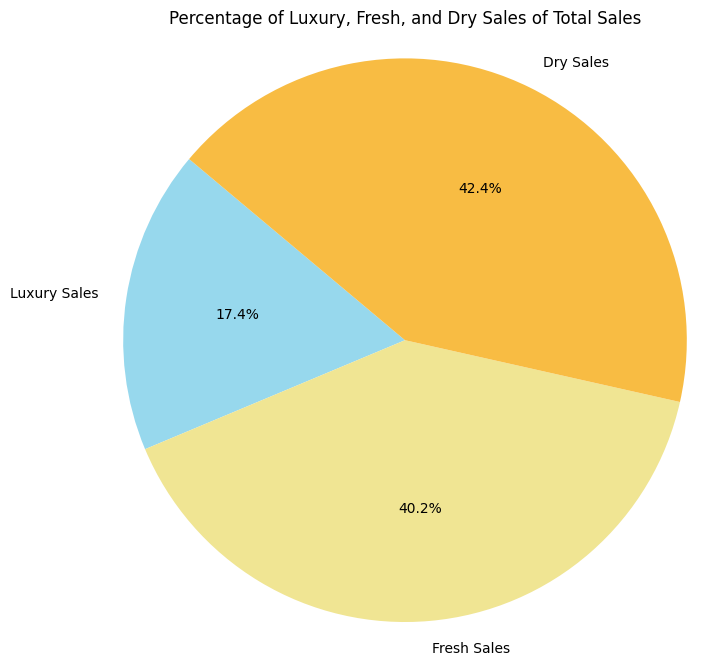

In [45]:

# Calculate total sales
train_data['total_sales'] = train_data['luxury_sales'] + train_data['fresh_sales'] + train_data['dry_sales']

# Calculate the percentage of each type of sale
luxury_percent = (train_data['luxury_sales'].sum() / train_data['total_sales'].sum()) * 100
fresh_percent = (train_data['fresh_sales'].sum() / train_data['total_sales'].sum()) * 100
dry_percent = (train_data['dry_sales'].sum() / train_data['total_sales'].sum()) * 100

# Create labels and sizes for the pie chart
labels = ['Luxury Sales', 'Fresh Sales', 'Dry Sales']
sizes = [luxury_percent, fresh_percent, dry_percent]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#97D8ED', '#F0E593', '#F8BC43'])
plt.title('Percentage of Luxury, Fresh, and Dry Sales of Total Sales')
plt.axis('equal')
plt.show()

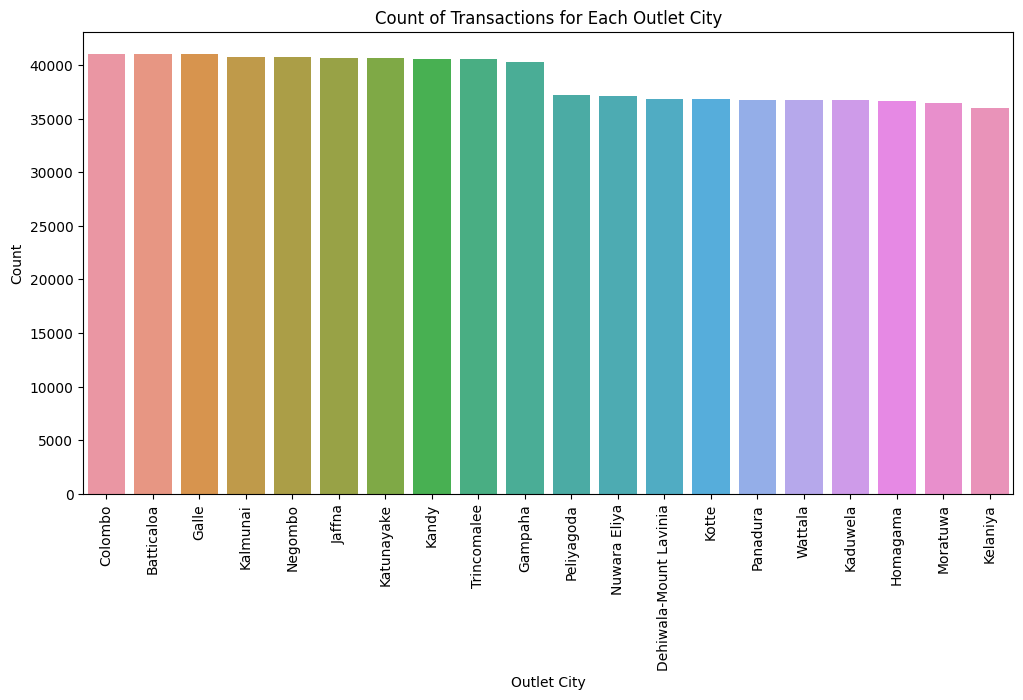

In [46]:
# Plot the count of transactions for each outlet_city
plt.figure(figsize=(12, 6))
sns.countplot(data=train_data, x='outlet_city', order=train_data['outlet_city'].value_counts().index)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Count of Transactions for Each Outlet City')
plt.xlabel('Outlet City')
plt.ylabel('Count')
plt.show()

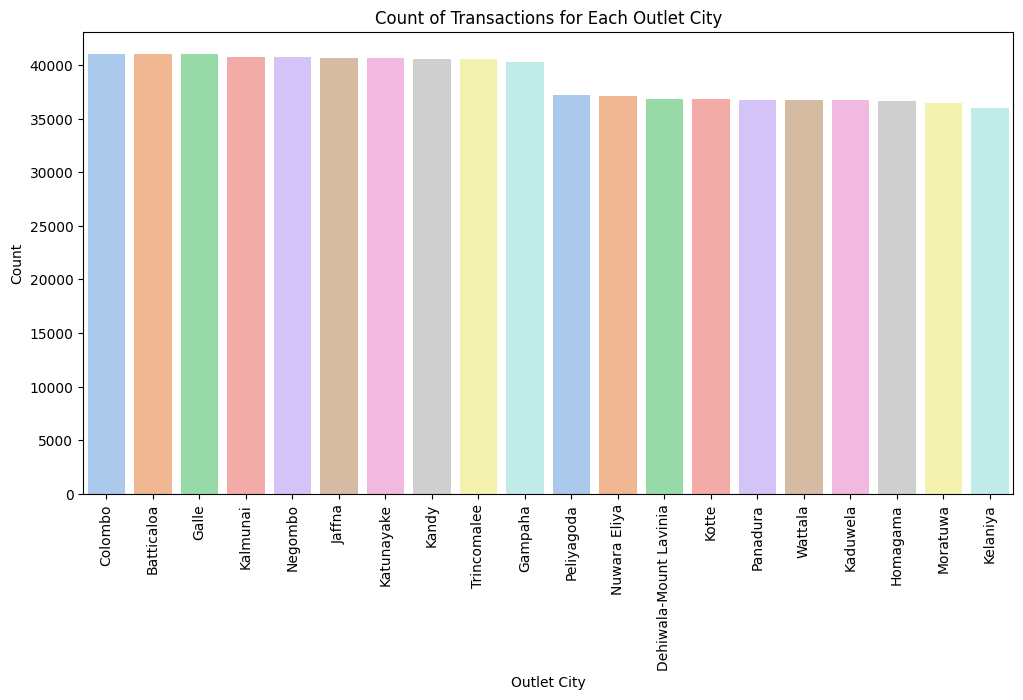

In [47]:
plt.figure(figsize=(12, 6))

# Use seaborn's built-in pastel color palette
sns.countplot(
    data=train_data, 
    x='outlet_city', 
    order=train_data['outlet_city'].value_counts().index,
    palette='pastel'
)

plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Count of Transactions for Each Outlet City')
plt.xlabel('Outlet City')
plt.ylabel('Count')
plt.show()

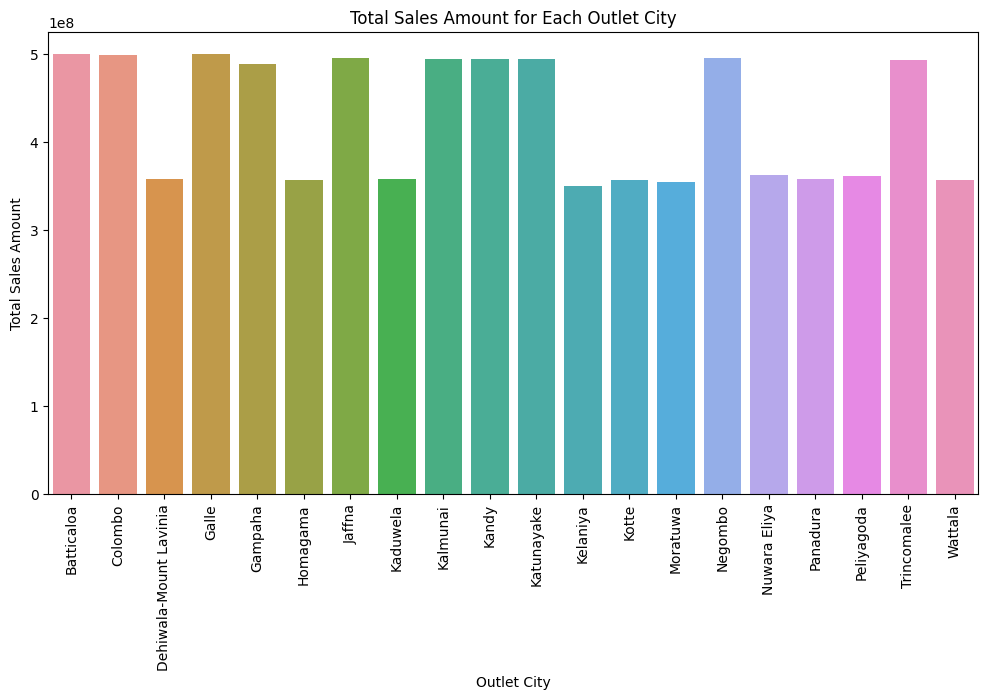

In [48]:
# Compute the total sales for each city
city_total_sales = train_data.groupby('outlet_city').agg({'luxury_sales': 'sum', 'fresh_sales': 'sum', 'dry_sales': 'sum'}).sum(axis=1)

# Plot the total sales amount for each outlet city
plt.figure(figsize=(12, 6))
sns.barplot(x=city_total_sales.index, y=city_total_sales.values)
plt.xticks(rotation=90)
plt.title('Total Sales Amount for Each Outlet City')
plt.xlabel('Outlet City')
plt.ylabel('Total Sales Amount')
plt.show()

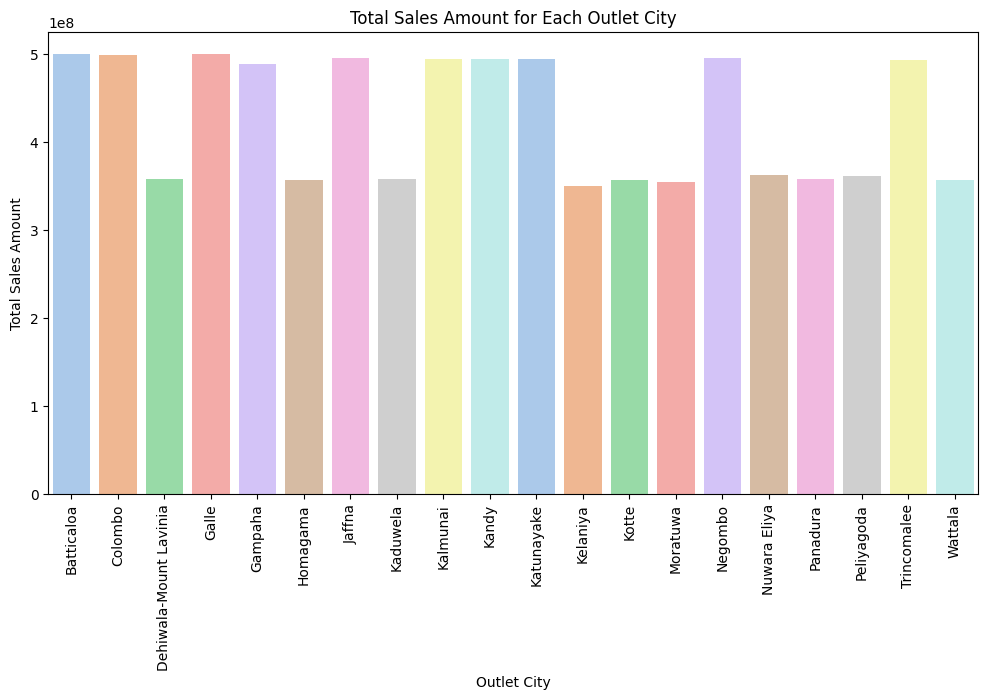

In [49]:
# Compute the total sales for each city
city_total_sales = train_data.groupby('outlet_city').agg({'luxury_sales': 'sum', 'fresh_sales': 'sum', 'dry_sales': 'sum'}).sum(axis=1)

plt.figure(figsize=(12, 6))

# Use seaborn's built-in pastel color palette
sns.barplot(x=city_total_sales.index, y=city_total_sales.values, palette='pastel')

plt.xticks(rotation=90)
plt.title('Total Sales Amount for Each Outlet City')
plt.xlabel('Outlet City')
plt.ylabel('Total Sales Amount')
plt.show()

In [50]:
# Find the city with the highest total sales
city_highest_sales = city_total_sales.idxmax()
highest_sales_amount = city_total_sales.max()

# Find the city with the lowest total sales
city_lowest_sales = city_total_sales.idxmin()
lowest_sales_amount = city_total_sales.min()

print("City with the highest total sales:", city_highest_sales)
print("Highest total sales amount:", highest_sales_amount)
print("\nCity with the lowest total sales:", city_lowest_sales)
print("Lowest total sales amount:", lowest_sales_amount)

City with the highest total sales: Batticaloa
Highest total sales amount: 500665652.24105096

City with the lowest total sales: Kelaniya
Lowest total sales amount: 350023391.6610688


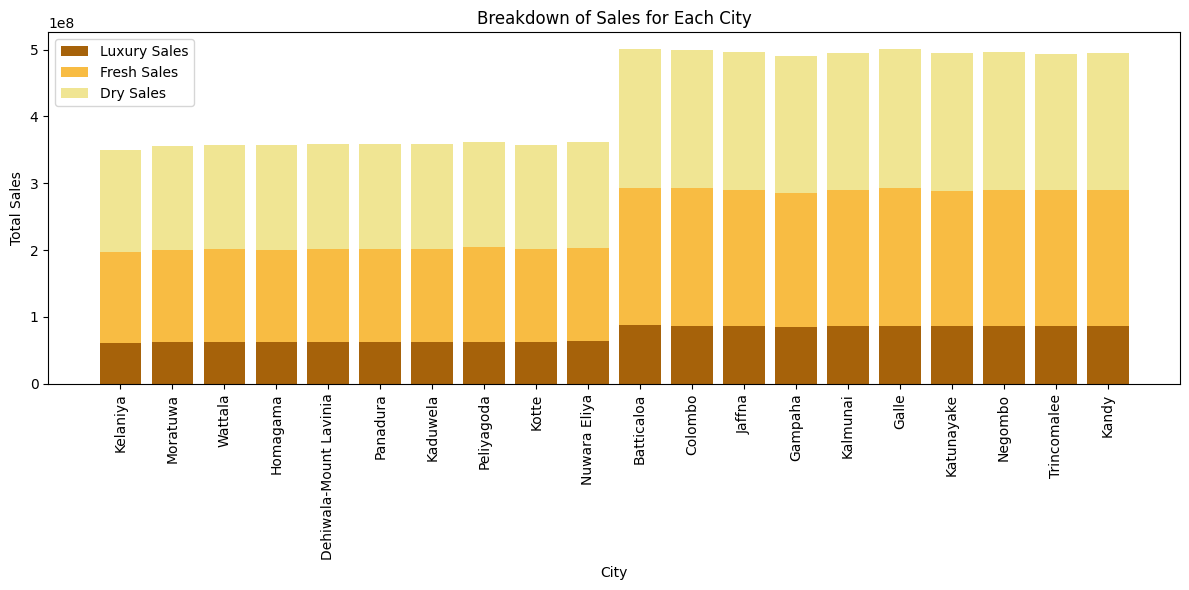

In [51]:
# Get unique cities
cities = train_data['outlet_city'].unique()

# Set up the figure and axes
plt.figure(figsize=(12, 6))

# Iterate over each city and plot the breakdown of sales
for city in cities:
    city_data = train_data[train_data['outlet_city'] == city]
    total_luxury_sales = city_data['luxury_sales'].sum()
    total_fresh_sales = city_data['fresh_sales'].sum()
    total_dry_sales = city_data['dry_sales'].sum()
    
    # Plot the breakdown for each city
    plt.bar(city, total_luxury_sales, color='#A6620A', label='Luxury Sales' if city == cities[0] else None)
    plt.bar(city, total_fresh_sales, color='#F8BC43', bottom=total_luxury_sales, label='Fresh Sales' if city == cities[0] else None)
    plt.bar(city, total_dry_sales, color='#F0E593', bottom=total_luxury_sales + total_fresh_sales, label='Dry Sales' if city == cities[0] else None)

# Add labels and title
plt.title('Breakdown of Sales for Each City')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend()  # Add legend
plt.tight_layout()
plt.show()

# Cluster Category Exploration

In [52]:
train_data.head()

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_catgeory,total_sales
0,10493832,Kelaniya,1209.60,756.00,5292.00,4,7257.60
1,10178643,Moratuwa,1590.12,1060.08,6007.12,1,8657.32
2,10513916,Wattala,2288.88,1481.04,9155.52,4,12925.44
3,10334589,Wattala,2274.94,1739.66,9099.76,4,13114.36
4,10458365,Kelaniya,2345.49,2069.55,9243.99,4,13659.03


In [53]:
# Find the count of transactions for each cluster
transaction_count_by_cluster = train_data['cluster_catgeory'].value_counts()

# Print the count of transactions for each cluster
print(transaction_count_by_cluster)

cluster_catgeory
1    188984
4    172439
6    169215
2    155064
3     48907
5     39540
Name: count, dtype: int64


In [54]:
# Calculate total sales for each cluster
total_sales_by_cluster = train_data.groupby('cluster_catgeory')[['luxury_sales', 'fresh_sales', 'dry_sales']].sum()

# Print the total sales for each cluster
total_sales_by_cluster

,luxury_sales,fresh_sales,dry_sales
cluster_catgeory,,,
1,2.954087e+08,4.136096e+08,1.594341e+09
2,1.937798e+08,1.045985e+09,2.713303e+08
3,1.990693e+08,1.991229e+08,1.990536e+08
4,3.015349e+08,2.155738e+08,1.162688e+09
5,1.283559e+08,1.284562e+08,1.283623e+08
6,3.697426e+08,1.425715e+09,2.643649e+08


In [55]:
# Find the category with the highest total sales
highest_total_sales_category = total_sales_by_cluster.sum(axis=1).idxmax()

# Find the category with the highest luxury sales
highest_luxury_sales_category = total_sales_by_cluster['luxury_sales'].idxmax()

# Find the category with the highest fresh sales
highest_fresh_sales_category = total_sales_by_cluster['fresh_sales'].idxmax()

# Find the category with the highest dry sales
highest_dry_sales_category = total_sales_by_cluster['dry_sales'].idxmax()

# Print the results
print("Category with the highest Total Sales:", highest_total_sales_category)
print("Category with the highest Luxury Sales:", highest_luxury_sales_category)
print("Category with the highest Fresh Sales:", highest_fresh_sales_category)
print("Category with the highest Dry Sales:", highest_dry_sales_category)

Category with the highest Total Sales: 1
Category with the highest Luxury Sales: 6
Category with the highest Fresh Sales: 6
Category with the highest Dry Sales: 1


In [56]:
# Group the data by cluster category and find the mode of outlet city in each group
most_common_city_by_category = train_data.groupby('cluster_catgeory')['outlet_city'].agg(lambda x: x.mode()[0])

# Print the result
print("Most common city in each category:")
print(most_common_city_by_category)

Most common city in each category:
cluster_catgeory
1      Katunayake
2      Peliyagoda
3         Negombo
4    Nuwara Eliya
5      Peliyagoda
6      Batticaloa
Name: outlet_city, dtype: object


In [57]:
# Group the data by cluster category and calculate minimum and maximum sales for each sale type
min_max_sales_by_category = train_data.groupby('cluster_catgeory').agg({
    'luxury_sales': ['min', 'max'],
    'fresh_sales': ['min', 'max'],
    'dry_sales': ['min', 'max']
})

# Print the result
print("Minimum and maximum sales in each category for each sale type:")
min_max_sales_by_category

Minimum and maximum sales in each category for each sale type:


luxury_sales          fresh_sales           dry_sales  \
                          min      max         min       max       min   
cluster_catgeory                                                         
1                      500.00  5030.40      750.15  12529.44    656.30   
2                      500.10  6912.15      898.30  11115.65    750.15   
3                      616.20  6999.65     1170.78  10198.07   1215.50   
4                      750.15  6204.33      500.00  12745.20    877.40   
5                      843.90  6044.69      903.10  12426.48    966.00   
6                      750.00  6719.08      866.58  13997.90    500.00   

                            
                       max  
cluster_catgeory            
1                 13999.30  
2                  9991.92  
3                 11328.85  
4                 10498.60  
5                  9163.59  
6                  8551.21

In [58]:
# Group the data by outlet city and sum the sales for each city
total_sales_by_city = train_data.groupby('outlet_city')[['luxury_sales', 'fresh_sales', 'dry_sales']].sum()

# Calculate the total sales for each city by adding luxury, fresh, and dry sales
total_sales_by_city['total_sales'] = total_sales_by_city.sum(axis=1)

# Sort the cities by total sales in descending order and get the top 5
top_5_cities = total_sales_by_city.sort_values(by='total_sales', ascending=False).head(5)

# Print the top 5 cities with the highest total sales
print("Top 5 Outlet Cities with the Highest Total Sales:")
top_5_cities

Top 5 Outlet Cities with the Highest Total Sales:


,luxury_sales,fresh_sales,dry_sales,total_sales
outlet_city,,,,
Batticaloa,8.726677e+07,2.061240e+08,2.072749e+08,5.006657e+08
Galle,8.723005e+07,2.055327e+08,2.078381e+08,5.006009e+08
Colombo,8.718620e+07,2.058648e+08,2.068589e+08,4.999100e+08
Negombo,8.664727e+07,2.039646e+08,2.058223e+08,4.964341e+08
Jaffna,8.642480e+07,2.041728e+08,2.051570e+08,4.957546e+08


In [59]:
test_data['total_sales'] = test_data['luxury_sales'] + test_data['fresh_sales'] + test_data['dry_sales']


# Feature Engineering

## Categorical Encoding

In [60]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Convert all values to strings
train_data['outlet_city'] = train_data['outlet_city'].astype(str)

# Fit and transform the target variable
train_data['outlet_city_encoded'] = label_encoder.fit_transform(train_data['outlet_city'])

# Create a dictionary to map encoded labels to original outlet names
label_map = {label: city for label, city in zip(label_encoder.transform(train_data['outlet_city']), train_data['outlet_city'])}

# Print the mapping
print("Encoded Label -> Outlet Name:")
for label, city in label_map.items():
    print(f"{label} -> {city}")


Encoded Label -> Outlet Name:
11 -> Kelaniya
13 -> Moratuwa
19 -> Wattala
5 -> Homagama
2 -> Dehiwala-Mount Lavinia
16 -> Panadura
7 -> Kaduwela
17 -> Peliyagoda
12 -> Kotte
15 -> Nuwara Eliya
0 -> Batticaloa
1 -> Colombo
6 -> Jaffna
4 -> Gampaha
8 -> Kalmunai
3 -> Galle
10 -> Katunayake
14 -> Negombo
18 -> Trincomalee
9 -> Kandy


In [61]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Concatenate train and test data for encoding consistency
combined_data = pd.concat([train_data, test_data])

# Convert all values to strings
combined_data['outlet_city'] = combined_data['outlet_city'].astype(str)

# Fit and transform the target variable
combined_data['outlet_city_encoded'] = label_encoder.fit_transform(combined_data['outlet_city'])

# Create a dictionary to map encoded labels to original outlet names
label_map = {label: city for label, city in zip(label_encoder.transform(combined_data['outlet_city']), combined_data['outlet_city'])}

# Print the mapping
print("Encoded Label -> Outlet Name:")
for label, city in label_map.items():
    print(f"{label} -> {city}")
# Splitting back into train and test sets based on index range
train_data = combined_data.iloc[:len(train_data)]
test_data = combined_data.iloc[len(train_data):]


# Verify encoded values in test set
print(test_data[['outlet_city', 'outlet_city_encoded']].head())

Encoded Label -> Outlet Name:
12 -> Kelaniya
15 -> Moratuwa
21 -> Wattala
6 -> Homagama
3 -> Dehiwala-Mount Lavinia
18 -> Panadura
8 -> Kaduwela
19 -> Peliyagoda
13 -> Kotte
17 -> Nuwara Eliya
1 -> Batticaloa
2 -> Colombo
7 -> Jaffna
5 -> Gampaha
9 -> Kalmunai
4 -> Galle
11 -> Katunayake
16 -> Negombo
20 -> Trincomalee
10 -> Kandy
0 -> Anuradhapura
14 -> Madawachiya
  outlet_city  outlet_city_encoded
0  Batticaloa                    1
1  Batticaloa                    1
2  Batticaloa                    1
3  Batticaloa                    1
4  Batticaloa                    1


In [62]:
duplicate_customer_ids = test_data[test_data.duplicated(['Customer_ID'], keep=False)]

if len(duplicate_customer_ids) > 0:
    print("Duplicate Customer_IDs found:")
    print(duplicate_customer_ids[['Customer_ID']])
else:
    print("No duplicate Customer_IDs found.")

No duplicate Customer_IDs found.


In [63]:
test_data.shape

(40749, 8)

In [64]:
test_data.head()

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_catgeory,total_sales,outlet_city_encoded
0,33574,Batticaloa,2686.50,3582.00,12537.00,NaN,18805.50,1
1,10089,Batticaloa,1717.56,2576.34,9446.58,NaN,13740.48,1
2,38329,Batticaloa,854.04,1242.24,5201.88,NaN,7298.16,1
3,11376,Batticaloa,1638.12,2320.67,9282.68,NaN,13241.47,1
4,12410,Batticaloa,1039.09,1518.67,5435.24,NaN,7993.00,1


In [65]:
# Drop the cluster_category column from test_data
test_data = test_data.drop(columns=['cluster_catgeory'])

# Verify that the column has been dropped
test_data.head()

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,total_sales,outlet_city_encoded
0,33574,Batticaloa,2686.50,3582.00,12537.00,18805.50,1
1,10089,Batticaloa,1717.56,2576.34,9446.58,13740.48,1
2,38329,Batticaloa,854.04,1242.24,5201.88,7298.16,1
3,11376,Batticaloa,1638.12,2320.67,9282.68,13241.47,1
4,12410,Batticaloa,1039.09,1518.67,5435.24,7993.00,1


## Feature Scaling of Sales Values

In [66]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical features in the training data
train_data[['luxury_sales', 'fresh_sales', 'dry_sales', 'total_sales']] = scaler.fit_transform(train_data[['luxury_sales', 'fresh_sales', 'dry_sales', 'total_sales']])
test_data[['luxury_sales', 'fresh_sales', 'dry_sales', 'total_sales']] = scaler.fit_transform(test_data[['luxury_sales', 'fresh_sales', 'dry_sales', 'total_sales']])


/tmp/ipykernel_33/1405907317.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[['luxury_sales', 'fresh_sales', 'dry_sales', 'total_sales']] = scaler.fit_transform(train_data[['luxury_sales', 'fresh_sales', 'dry_sales', 'total_sales']])


In [67]:
test_data.head()

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,total_sales,outlet_city_encoded
0,33574,Batticaloa,0.756537,-0.257025,2.300092,2.020746,1
1,10089,Batticaloa,-0.208780,-0.557282,1.394059,0.699060,1
2,38329,Batticaloa,-1.069072,-0.955602,0.149621,-0.982025,1
3,11376,Batticaloa,-0.287923,-0.633617,1.346008,0.568846,1
4,12410,Batticaloa,-0.884714,-0.873069,0.218036,-0.800711,1


In [68]:
test_data.shape

(40749, 7)

In [69]:
duplicate_customer_ids = test_data[test_data.duplicated(['Customer_ID'], keep=False)]

if len(duplicate_customer_ids) > 0:
    print("Duplicate Customer_IDs found:")
    print(duplicate_customer_ids[['Customer_ID']])
else:
    print("No duplicate Customer_IDs found.")

No duplicate Customer_IDs found.


## Encoding the Cluster Category Column

In [70]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'cluster_catgeory' column in the training data
train_data['cluster_catgeory_encoded'] = label_encoder.fit_transform(train_data['cluster_catgeory'].astype(str))+1

# Display the unique encoded values
print("Encoded Unique Values for cluster_catgeory:", train_data['cluster_catgeory_encoded'].unique())

Encoded Unique Values for cluster_catgeory: [4 1 2 5 3 6]


/tmp/ipykernel_33/945054091.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['cluster_catgeory_encoded'] = label_encoder.fit_transform(train_data['cluster_catgeory'].astype(str))+1


In [71]:
train_data.head()

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_catgeory,total_sales,outlet_city_encoded,cluster_catgeory_encoded
0,10493832,Kelaniya,-0.709496,-1.101403,0.180599,4,-0.982414,12,4
1,10178643,Moratuwa,-0.330511,-1.010213,0.390355,1,-0.617601,15,1
2,10513916,Wattala,0.365430,-0.883971,1.313828,4,0.494812,21,4
3,10334589,Wattala,0.351546,-0.806413,1.297473,4,0.544051,21,4
4,10458365,Kelaniya,0.421811,-0.707482,1.339778,4,0.686010,12,4


# Model Building

In [72]:
# Selecting columns for the modeling dataset
training_data = train_data[['luxury_sales', 'fresh_sales', 'dry_sales', 'total_sales', 'outlet_city_encoded', 'cluster_catgeory_encoded']]

# Display the new DataFrame
training_data.head()

,luxury_sales,fresh_sales,dry_sales,total_sales,outlet_city_encoded,cluster_catgeory_encoded
0,-0.709496,-1.101403,0.180599,-0.982414,12,4
1,-0.330511,-1.010213,0.390355,-0.617601,15,1
2,0.365430,-0.883971,1.313828,0.494812,21,4
3,0.351546,-0.806413,1.297473,0.544051,21,4
4,0.421811,-0.707482,1.339778,0.686010,12,4


In [73]:
# Assuming your dataframe is named training_data
training_data_copy = training_data.copy()
training_data_copy.rename(columns={'cluster_catgeory_encoded': 'cluster_category', 'outlet_city_encoded': 'outlet_city'}, inplace=True)
training_data = training_data_copy

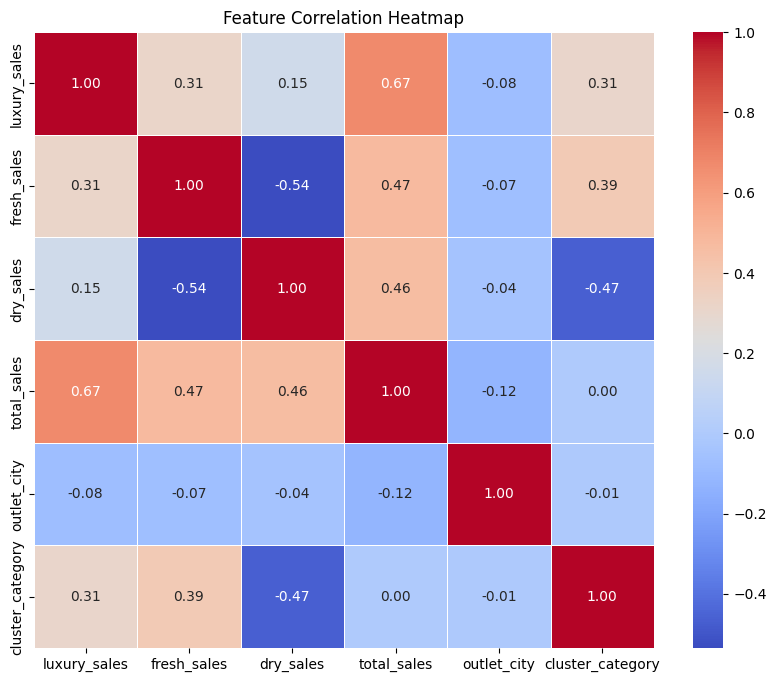

In [74]:
# Compute the correlation matrix
correlation_matrix = training_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

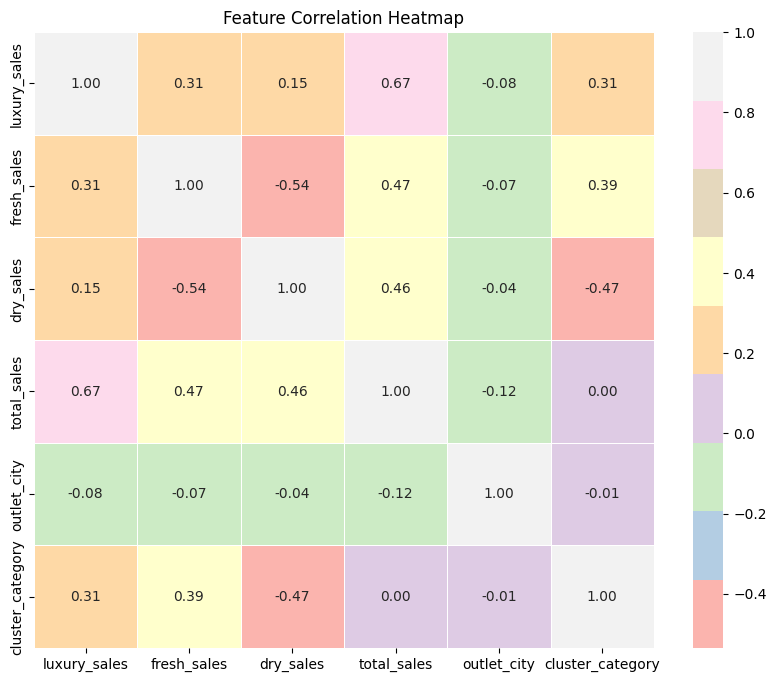

In [97]:
# Compute the correlation matrix
correlation_matrix = training_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))

# Use seaborn's pastel color palette for the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='Pastel1', fmt=".2f", linewidths=0.5)

plt.title('Feature Correlation Heatmap')
plt.show()

# Spliting Train and Test Set

In [75]:
# Assuming your dataframe is named training_data
training_dataa = training_data.sample(n=400000, random_state=42)  # Randomly sample 400,000 data points

In [76]:
# Define the features and target variable
X = training_dataa.drop(columns=['cluster_category'])  
y = training_dataa['cluster_category'] 

In [77]:
X.head()

,luxury_sales,fresh_sales,dry_sales,total_sales,outlet_city
321730,-1.034042,0.058165,-1.032653,-1.137637,21
211675,-0.473333,1.275025,-0.600089,0.451026,18
472686,-0.703839,-0.831142,0.864352,-0.138485,9
66177,-0.624381,-0.985436,0.125473,-0.908337,15
344664,2.743618,0.074377,0.040468,0.818573,19


In [78]:
y.head()

321730    2
211675    2
472686    1
66177     4
344664    5
Name: cluster_category, dtype: int64

In [79]:
# Split the data into train and test sets (70:30 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [80]:
X_train.shape

(280000, 5)

In [81]:
X_test.shape

(120000, 5)

In [82]:
test_data.head()

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,total_sales,outlet_city_encoded
0,33574,Batticaloa,0.756537,-0.257025,2.300092,2.020746,1
1,10089,Batticaloa,-0.208780,-0.557282,1.394059,0.699060,1
2,38329,Batticaloa,-1.069072,-0.955602,0.149621,-0.982025,1
3,11376,Batticaloa,-0.287923,-0.633617,1.346008,0.568846,1
4,12410,Batticaloa,-0.884714,-0.873069,0.218036,-0.800711,1


# Modeling using Random Forest

In [83]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Predict the target variable on the test data
y_pred = rf_classifier.predict(X_test)

# Check model accuracy

In [84]:
# Evaluate the accuracy of the model Random Forest
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9988916666666666


In [85]:
duplicate_customer_ids = test_data[test_data.duplicated(['Customer_ID'], keep=False)]

if len(duplicate_customer_ids) > 0:
    print("Duplicate Customer_IDs found:")
    print(duplicate_customer_ids[['Customer_ID']])
else:
    print("No duplicate Customer_IDs found.")

No duplicate Customer_IDs found.


In [86]:
# Standardize the features by scaling them to have mean 0 and variance 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors as needed

# Train the KNN classifier on the training data
knn.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = knn.predict(X_test_scaled)


In [87]:

# Evaluate the accuracy of the KNN model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.999675


In [88]:
test_data.head()

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,total_sales,outlet_city_encoded
0,33574,Batticaloa,0.756537,-0.257025,2.300092,2.020746,1
1,10089,Batticaloa,-0.208780,-0.557282,1.394059,0.699060,1
2,38329,Batticaloa,-1.069072,-0.955602,0.149621,-0.982025,1
3,11376,Batticaloa,-0.287923,-0.633617,1.346008,0.568846,1
4,12410,Batticaloa,-0.884714,-0.873069,0.218036,-0.800711,1


In [89]:
train_data.head()

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_catgeory,total_sales,outlet_city_encoded,cluster_catgeory_encoded
0,10493832,Kelaniya,-0.709496,-1.101403,0.180599,4,-0.982414,12,4
1,10178643,Moratuwa,-0.330511,-1.010213,0.390355,1,-0.617601,15,1
2,10513916,Wattala,0.365430,-0.883971,1.313828,4,0.494812,21,4
3,10334589,Wattala,0.351546,-0.806413,1.297473,4,0.544051,21,4
4,10458365,Kelaniya,0.421811,-0.707482,1.339778,4,0.686010,12,4


In [90]:
train_data_new = train_data[['luxury_sales', 'fresh_sales', 'dry_sales', 'total_sales', 'outlet_city_encoded', 'cluster_catgeory_encoded']]

In [91]:
train_data_new.head()

,luxury_sales,fresh_sales,dry_sales,total_sales,outlet_city_encoded,cluster_catgeory_encoded
0,-0.709496,-1.101403,0.180599,-0.982414,12,4
1,-0.330511,-1.010213,0.390355,-0.617601,15,1
2,0.365430,-0.883971,1.313828,0.494812,21,4
3,0.351546,-0.806413,1.297473,0.544051,21,4
4,0.421811,-0.707482,1.339778,0.686010,12,4


In [92]:
test_data_new = test_data[['luxury_sales', 'fresh_sales', 'dry_sales', 'total_sales', 'outlet_city_encoded']]

In [93]:
test_data_new.head()

,luxury_sales,fresh_sales,dry_sales,total_sales,outlet_city_encoded
0,0.756537,-0.257025,2.300092,2.020746,1
1,-0.208780,-0.557282,1.394059,0.699060,1
2,-1.069072,-0.955602,0.149621,-0.982025,1
3,-0.287923,-0.633617,1.346008,0.568846,1
4,-0.884714,-0.873069,0.218036,-0.800711,1


In [94]:
# Assuming train_data and test_data are DataFrames with the same structure
# Prepare the data
X_train = train_data_new.drop(columns=['cluster_catgeory_encoded'])  # Features for training
y_train = train_data_new['cluster_catgeory_encoded']  # Target variable for training

X_test = test_data_new # Features for testing

# Initialize KNN model
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

# Train the model
knn.fit(X_train, y_train)

# Predict on the test data
y_pred = knn.predict(X_test)


In [95]:
predictions_df = pd.DataFrame({
    'Customer_ID': test_data['Customer_ID'],  # Customer_ID from train_data
    'cluster_category': y_pred  # Predicted cluster_category
})

# Save predictions to CSV
predictions = predictions_df.to_csv('predictions.csv', index=False)

# Verify that the CSV file is saved
print("Predictions saved to predictions.csv")

Predictions saved to predictions.csv


In [96]:
predictions_df

,Customer_ID,cluster_category
0,33574,1
1,10089,1
2,38329,1
3,11376,1
4,12410,1
...,...,...
40744,33698,5
40745,4185,5
40746,28664,5
40747,11874,5
